In [4]:
import sys
sys.path.append('T:\Traders\Mark Gillis\Code\Sitka') # add sitka code folder for IRO and FinDates import
from Sitka import fdate
from Sitka import blp

import pandas as pd
import numpy as np
import datetime 

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
#import pmdarima as pm
from sklearn.metrics import mean_squared_error

import seaborn as sns
from sklearn.preprocessing import StandardScaler 
#import prince
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('T:/Traders/YuyingQian/HistoricalClose/USDEUR.csv')
df.set_index('Date',inplace=True)
df=df.dropna()

In [3]:
df.tail(15)

,USD,EUR,FX,FXBasis,USDOIS,EUROIS,ESTROIS
Date,,,,,,,
2020-10-29,1.2564,-0.0509,1.1674,-9.125,19.200,5.500,13.990
2020-10-30,1.3129,-0.0540,1.1647,-8.000,19.275,4.920,13.390
2020-11-02,1.2594,-0.0430,1.1641,-8.625,19.100,4.800,13.275
2020-11-03,1.3255,-0.0260,1.1715,-8.500,18.875,4.600,13.150
2020-11-04,1.2148,-0.0380,1.1726,-7.750,18.885,4.800,13.420
2020-11-05,1.2007,-0.0380,1.1826,-7.750,18.625,4.780,13.300
2020-11-06,1.2720,-0.0110,1.1874,-7.875,18.500,4.700,13.270
2020-11-09,1.3703,0.0765,1.1813,-8.875,18.700,4.175,13.010
2020-11-10,1.4006,0.0992,1.1815,-9.125,18.750,3.815,12.530


In [85]:
df['Spread'] = 100 * (df['USD'] - df ['EUR'])

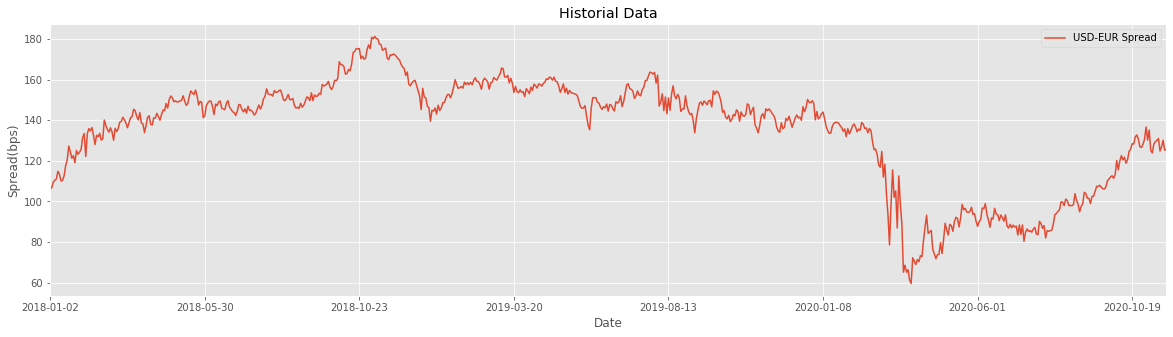

In [96]:
# Plot historical price data
fig, ax = plt.subplots(figsize=(20,5))
df['Spread'].plot(ax=ax,label='USD-EUR Spread')
plt.title('Historial Data')
plt.xlabel('Date')
plt.ylabel('Spread(bps)')
plt.legend()
plt.show()

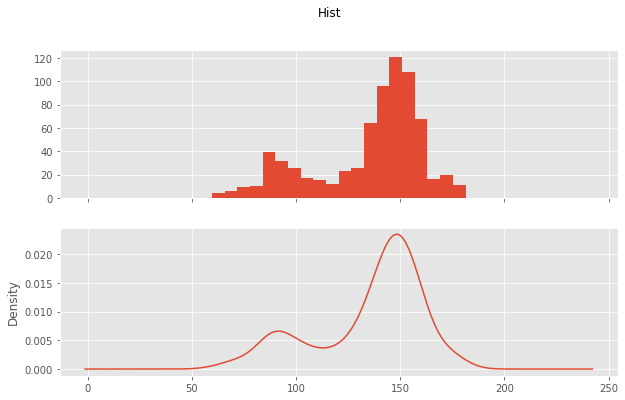

In [97]:
# Histogram/density plots of time series
fig, ax = plt.subplots(2, figsize=(10,6), sharex=True)
fig.suptitle('Hist')
df['Spread'].hist(ax=ax[0], bins=20)
df['Spread'].plot(kind='kde', ax=ax[1])
plt.show()

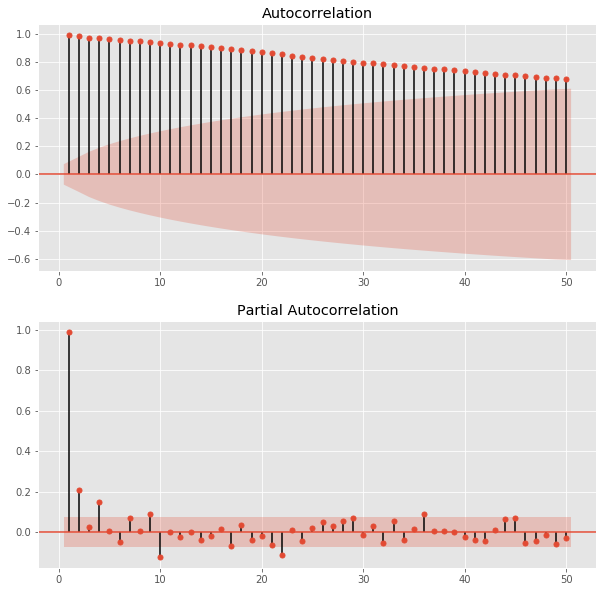

In [86]:
# ACF and PACF plots of time series
def plot_acf_pacf(df):
    # Create figure
    fig, ax = plt.subplots(2, figsize=(10,10))
    # Make ACF plot
    plot_acf(df, lags=50, zero=False, ax=ax[0])
    # Make PACF plot
    plot_pacf(df, lags=50, zero=False, ax=ax[1])
    # Show plots
    return plt.show()

plot_acf_pacf(df['Spread'])

ADF Statistic: -9.236904
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


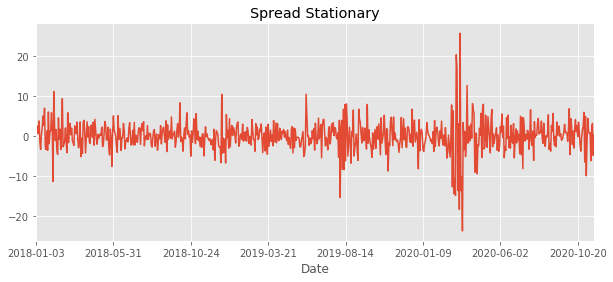

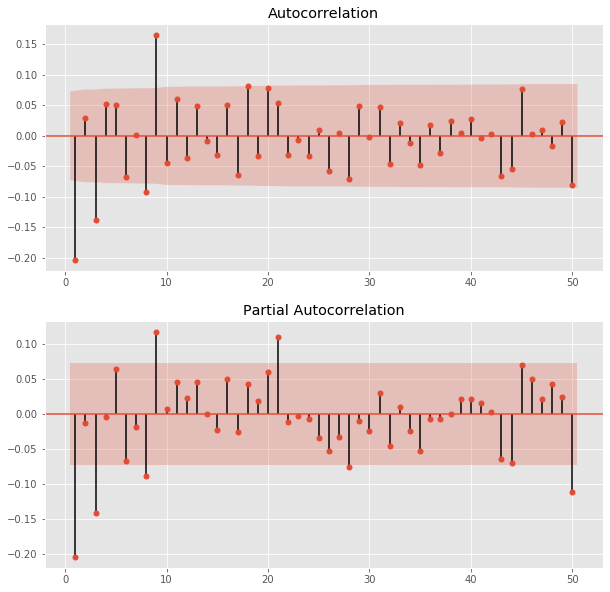

In [98]:
# Transform data from non-stationary to stationary
X = df['Spread']
# Method 1: difference data
stationary = X.diff(1)
# # Method 2: take the log
# stationary = np.log(X)
# # Method 3: take the square root 
# stationary = np.sqrt(X)
# # Method 4: take the proprtional change
# stationary = X.pct_change(1)
stationary.dropna(axis=0, inplace=True)

# The augmented Dicky-Fuller test - check if stationary
result = adfuller(stationary)
# test statistic - more negative means more likely to be stationary
print('ADF Statistic: %f' % result[0])
# p-value - reject null hypothesis: non-stationary
print('p-value: %f' % result[1])
# critical test statistics - p-values: test statistic for null hypothesis
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# plot stationary dataset
stationary.plot(figsize=(10,4))
plt.title('Spread Stationary')
plt.show()

# plot ACF & PACF of stationary dataset
plot_acf_pacf(stationary)

In [99]:
# Searching over SARIMA model orders
class Auto_Arima():
    def __init__(self, df, start_p=1, start_q=1, max_p=10, max_q=10,\
        seasonal=False, information_criterion='aic'):
        self.df = df
        self.start_p = start_p
        self.start_q = start_q
        self.max_p = max_p
        self.max_q = max_q
        self.seasonal = seasonal
        self.information_criterion = information_criterion

    def arima_results(self):
        results = pm.auto_arima(
            self.df,
            start_p = self.start_p,
            start_q = self.start_q,
            max_p = self.max_p,
            max_q = self.max_q,
            seasonal = self.seasonal,
            # m = 14,
            # D = 1,
            # start_P = 1,
            # start_Q = 1,
            # max_P = 10,
            # max_Q = 10,
            information_criterion = self.information_criterion,
            trace = False,
            error_action = 'ignore',
            suppress_warnings=True,
            stepwise = True,
            scoring = 'mse'
        )
        return results

Train: 506, Test: 217


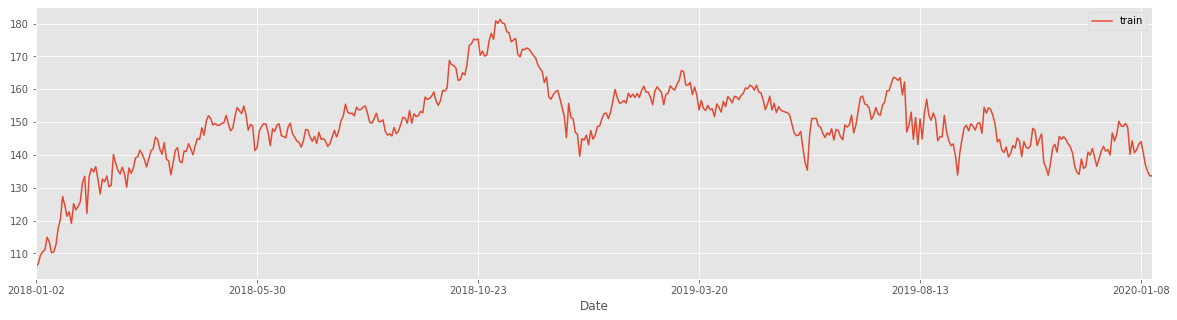

In [102]:
# Train test split
def train_test_split(X, size=0.7):
    train = X[:int(X.shape[0]*size)]
    test = X[int(X.shape[0]*size):]
    return train, test

train, test = train_test_split(X=df['Spread'], size=0.7)
print(f'Train: {len(train)}, Test: {len(test)}')

# Plot train & test datasets
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(train,label='train')
ax.plot(test,label='test')
ax.legend()
plt.title("Train vs Test Datasets")
plt.show()

In [103]:
# Fit model with auto-arima
arima_model = Auto_Arima(train)
results = arima_model.arima_results()

# Check residuals
# Prob(Q) - p-value for null hypothesis that residuals are uncorrelated
# Prob(JB) - p-value for null hypothesis that residuals are normal
print(results.summary())

NameError: name 'pm' is not defined

In [ ]:
# Residuals are not correlated and are not normally distributed

# Plot diagnostics - check residuals:
# 1.Standardized residual - should be white noise
# 2.Histogram plus estimated density - expected normal distribution
# and kde overlap each other
# 3.Normal Q-Q - all points should lay on red line, except perhaps
# for some values at both ends
# 4.Correlogram - acf plot, 95% should not be significant
plot_diag = results.plot_diagnostics(figsize=(16,10))

In [13]:
# Out-of-sample multi-step-forecast based on auto_arima results
predicted = results.predict(n_periods=len(test))
predicted = pd.DataFrame(predicted, index=test.index, columns=['predicted'])

def plot_train_test(train, test, df):
    # Plot the predictions for validation set
    plt.figure(figsize=(16,6))
    #plt.plot(train, label='train')
    plt.plot(test, label='test')
    plt.plot(df, label='predicted')
    plt.title('Prediction for USD-EUR Spread')
    plt.legend()
    plt.show()

    # calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, df))
    print(f'RMSE: {rmse:.2f}')

plot_train_test(train, test, predicted)

NameError: name 'results' is not defined

In [ ]:
# ARIMA multi-step-forecast is pretty bad, so let's compare it with one-step-forecast
def one_step_forecast():
    predicted, conf_int = results.predict(n_periods=1, return_conf_int=True)
    return (
        predicted.tolist()[0],
        np.asarray(conf_int).tolist()[0])

predictions = []
confidence_intervals = []

for x in test:
    predicted, conf = one_step_forecast()
    predictions.append(predicted)
    confidence_intervals.append(conf)

    # Updates the existing model
    results.update(x)
    
# Out-of-sample one-step-forecast based on auto_arima results
predicted = pd.DataFrame(predictions, index=test.index, columns=['predicted'])

# Plot real price vs one-step-forecast
plot_train_test(train, test, predicted)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(test, predictions))
#print(f'RMSE: {rmse:.2f}')

In [ ]:
# Forecast with confidence intervals
lower_limits = [row[0] for row in confidence_intervals]
upper_limits = [row[1] for row in confidence_intervals]
# Plot predictions with conf_int
plt.figure(figsize=(16,6))
#plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(predicted, label='predicted')
plt.fill_between(test.index, lower_limits, upper_limits, color='pink', label='confidence limits')
plt.title('Prediction with confidence intervals')
plt.legend()
plt.show()

In [ ]:
# Let's make predictions other way
# SARIMAX 
# one-step-ahead in-sample predictions with uncertainty
def sarimax_model(df, trend='ct', steps=100, dynamic=False):
    model = SARIMAX(df, order=(7,1,7), trend=trend)
    results = model.fit()
    one_step_forecast = results.get_prediction(start=-steps, dynamic=dynamic)
    # Get in-sample predicted mean values
    predictions = one_step_forecast.predicted_mean
    # Get confidence intervals of in-sample forecasts
    confidence_intervals = one_step_forecast.conf_int()
    lower_limits = confidence_intervals['lower Spread']
    upper_limits = confidence_intervals['upper Spread']
    return predictions, lower_limits, upper_limits

# Plot real data
def plot_sarimax_pred(df, steps=100):
    plt.figure(figsize=(16,6))
    plt.plot(df.index[-steps:], df[-steps:], 
            color='b', label='real data')
    # Plot predictions 
    plt.plot(predictions.index, predictions, 
            color='g', label='predicted')
    # Plot confidence limits
    plt.fill_between(lower_limits.index, lower_limits,
            upper_limits, color='pink', label='confidence limits')
    plt.legend()
    plt.show()

In [ ]:
# Run model
predictions, lower_limits, upper_limits =sarimax_model(df=test, trend='ct', steps=100, dynamic=False)
# Plot one-step-forecast
plot_sarimax_pred(df=test, steps=100)

In [ ]:
# Dynamic forecast for next 50 days
# Run model
predictions, lower_limits, upper_limits = sarimax_model(df=df['Spread'], trend='ct', steps=50, dynamic=True)
# Plot dynamic forecast
plot_sarimax_pred(df=df['Spread'], steps=400)

In [ ]:
# One-step-forecast for next 50 days
# Run model
predictions, lower_limits, upper_limits = sarimax_model(df=df['Spread'], trend='ct', steps=50, dynamic=False)
# Plot one-step-forecast for comparison with multi-step-forecast
plot_sarimax_pred(df=df['Spread'], steps=400)    


# Compare predictions with real data
forecast_vs_real = pd.concat([round(df['Spread'][-50:],2), round(predictions,2)], axis=1)
forecast_vs_real.columns = ['Real Price', 'Forecast']
forecast_vs_real['Error_%'] = round(abs(forecast_vs_real['Forecast'] - forecast_vs_real['Real Price'])/\
                        forecast_vs_real['Real Price'] * 100, 1)
print(forecast_vs_real.head(5))
print()
print(f"Mean error: {round(forecast_vs_real['Error_%'].mean(),1)} %")